# OBB Diag with artificial intelligence
Context : An EOM request a diagnostic for gasoline engine air system. Current platform SW do not match the EOM expectations.

Different engine Fields has been performed with different configurations.
Test cases 1, 7 and 8 should be not diaged
Test cases 2, 3, 7bis and 8bis should be diaged

In the CSV files of train / test sets are described bellow :

For all the datasets :
 - col 1 : RPM
 - col 2 : load
 - col 3 : conf (number in [1 2 3 7 8 10 11]) > 7 classes corresponding to the engine field
 - col 4 : if the blowby is leaking or not (number in [0 1]) > binary classification
 - col 5 : engine Load
 - col 5 > 51 : 46 * 5 Cranck angle based Pressure for new sensor in the blowby system
 - col 52 > 98 : 46 * 5 Cranck angle based Pressure for Outlet compressor sensor
 - 99 > 145 : 46 * 5 Cranck angle based Pressure for inlet manifold sensor
 
When I say 46 * 5 Cranck angle based pressure data, we actually have 1ms sampled pressure data, and I interpolated this data every 5 Cranck Angle degree, so as for exemple, col 5 we have a certain pressure, and col 6 we have the same pressure 5 cranck angle degrees later.
 
I have chooen to interpolate with 5 CAD (cranckangle degrees) because I have 1 ms deta, and the min RPM is 750. (at 750 RPM, 1 ms is 5CAD)

Here is a snaphot of the data @ 2500 RPM :

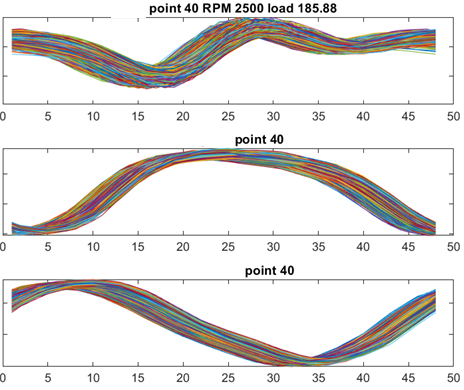

# Import Data 

 - DS1 : same OP
 - DS2 : different OP

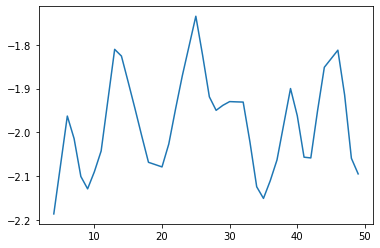

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('TrainSet1_sameOP.csv', header=None)
test = pd.read_csv('TestSet1_sameOP.csv', header=None)

data = data.rename(columns = {0:'RPM',1:'load',2:'conf',3:'bin'})
test = test.rename(columns = {0:'RPM',1:'load',2:'conf',3:'bin'})

one = data.iloc[:,4:50] # compressor outlet pressure
two = data.iloc[:,51:97] # inlet manifold pressure
three = data.iloc[:,98:144] # new PCV sensor

dic_map_class = {1:"1",
                2:"2",
                3:"3",
                4:"4",
                5:"5",
                6:"5bis",
                7:"7",
                8:"8bis",
                9:"9",
                10:"8",
                11:"7bis"}

def mapping(inp):
    return dic_map_class[inp]

data["class_target_str"] = data["conf"].apply(mapping)
test["class_target_str"] = test["conf"].apply(mapping)

def myround(x, base=50):
    return base * round(x/base)
data['round_RPM'] = data['RPM'].apply(myround)
test['round_RPM'] = test['RPM'].apply(myround)

one.iloc[1,:].plot()

data=data.dropna()
data=data[(data['round_RPM'] < 3500) & (data['load']>30) & (data['round_RPM'] >1400)]
test=test.dropna()
test=test[(test['round_RPM'] < 3500) & (test['load']>30) & (test['round_RPM'] >1400)]

In [2]:
X_train = data.drop(['conf','bin','class_target_str','round_RPM'], axis=1).dropna()[data.dropna()['round_RPM'] < 3500]
X_test = test.drop(['conf','bin','class_target_str','round_RPM'], axis=1).dropna()
y_train = data.dropna()['bin']
y_test = test.dropna()['bin']
conf_train = data.dropna()['class_target_str']
conf_test = test.dropna()['class_target_str']
print(X_train.shape)
print(y_train.shape)
X_train.head()

(234301, 143)
(234301,)


,RPM,load,4,5,6,7,8,9,10,11,...,135,136,137,138,139,140,141,142,143,144
16414,1499.4,31.759,-1.4216,-1.3352,-1.2491,-1.16370,-0.91733,-0.52674,-0.28768,-0.09588,...,-344.15,-332.11,-318.54,-299.87,-282.87,-267.85,-258.80,-252.44,-251.51,-251.55
16415,1499.4,31.759,-1.3681,-1.3231,-1.1219,-0.96334,-0.82952,-0.65475,-0.48898,-0.45058,...,-349.88,-339.67,-324.06,-305.89,-286.05,-272.85,-261.56,-257.92,-255.75,-256.79
16416,1499.4,31.759,-1.2184,-1.3006,-1.2095,-1.06890,-0.79906,-0.61281,-0.62157,-0.55977,...,-354.24,-344.82,-327.62,-309.82,-290.34,-276.21,-267.12,-264.55,-264.02,-265.69
16417,1499.4,31.759,-1.4354,-1.3137,-1.1899,-1.06380,-0.95126,-0.84461,-0.67303,-0.50886,...,-352.32,-339.61,-325.60,-306.71,-289.91,-276.54,-267.79,-262.12,-260.78,-260.53
16418,1499.4,31.759,-1.3973,-1.2214,-1.1389,-1.01240,-0.84751,-0.61073,-0.35705,-0.27070,...,-346.45,-334.03,-317.05,-299.00,-280.40,-269.26,-260.07,-257.58,-256.77,-258.55


In [3]:
# scaling of the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_trainS = scaler.transform(X_train)
X_testS = scaler.transform(X_test)

In [4]:
standard_pressure = 1013.25 # bar
one = data.iloc[:,4:50] # compressor outlet pressure
two = data.iloc[:,51:97] # inlet manifold pressure
three = data.iloc[:,98:144]
    
data['min_s1'] = one.min(axis=1)
data['min_s2'] = two.min(axis=1)+standard_pressure
data['min_s3'] = three.min(axis=1)+standard_pressure
data['max_s1'] = one.max(axis=1)
data['max_s2'] = two.max(axis=1)+standard_pressure
data['max_s3'] = three.max(axis=1)+standard_pressure
data['mean_s1'] = one.mean(axis=1)
data['mean_s2'] = two.mean(axis=1)+standard_pressure
data['mean_s3'] = three.mean(axis=1)+standard_pressure
data['std_s1'] = one.std(axis=1)
data['std_s2'] = two.std(axis=1)
data['std_s3'] = three.std(axis=1)

one = test.iloc[:,4:50] # compressor outlet pressure
two = test.iloc[:,51:97] # inlet manifold pressure
three = test.iloc[:,98:144]

test['min_s1'] = one.min(axis=1)
test['min_s2'] = two.min(axis=1)+standard_pressure
test['min_s3'] = three.min(axis=1)+standard_pressure
test['max_s1'] = one.max(axis=1)
test['max_s2'] = two.max(axis=1)+standard_pressure
test['max_s3'] = three.max(axis=1)+standard_pressure
test['mean_s1'] = one.mean(axis=1)
test['mean_s2'] = two.mean(axis=1)+standard_pressure
test['mean_s3'] = three.mean(axis=1)+standard_pressure
test['std_s1'] = one.std(axis=1)
test['std_s2'] = two.std(axis=1)
test['std_s3'] = three.std(axis=1)

features_eng = ['RPM','load','min_s1','min_s2','min_s3',
                            'max_s1','max_s2','max_s3',
                            'mean_s1','mean_s2','mean_s3',
                            'std_s1','std_s2','std_s3']

In [5]:
X_train = data.drop(['conf','bin','class_target_str','round_RPM'], axis=1).dropna()[data.dropna()['round_RPM'] < 3500][features_eng]
X_test = test.drop(['conf','bin','class_target_str','round_RPM'], axis=1).dropna()[features_eng]
y_train = data.dropna()['bin']
y_test = test.dropna()['bin']
conf_train = data.dropna()['class_target_str']
conf_test = test.dropna()['class_target_str']
print(X_train.shape)
print(y_train.shape)
X_train.head()

(234301, 14)
(234301,)


,RPM,load,min_s1,min_s2,min_s3,max_s1,max_s2,max_s3,mean_s1,mean_s2,mean_s3,std_s1,std_s2,std_s3
16414,1499.4,31.759,-2.0182,1015.340600,638.00,-0.09588,1018.8476,764.13,-1.309620,1016.774437,688.189130,0.521460,0.929427,43.259592
16415,1499.4,31.759,-2.1478,1015.371500,633.82,-0.42634,1018.6141,758.92,-1.407829,1016.651504,683.569783,0.523748,0.721163,43.258402
16416,1499.4,31.759,-2.4046,1014.607900,627.82,-0.43990,1018.0318,754.01,-1.465945,1016.754370,677.921087,0.583512,0.724359,43.332975
16417,1499.4,31.759,-2.5689,1014.127810,627.31,-0.42474,1018.0886,752.47,-1.592150,1015.982396,675.594348,0.662456,0.922896,41.769434
16418,1499.4,31.759,-2.6379,1013.161115,632.69,-0.24731,1018.0991,756.48,-1.559302,1015.713984,681.948261,0.701283,1.111996,42.148071


In [6]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
scaler = StandardScaler().fit(X_train)
X_trainS = scaler.transform(X_train)
X_testS = scaler.transform(X_test)


In [7]:
X_trainS = pd.DataFrame(X_trainS, columns = X_train.columns)
X_testS = pd.DataFrame(X_testS, columns = X_train.columns)

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
class Distiller(keras.Model):

  # Needs both the student and teacher models to create an instance of this class
  def __init__(self, student, teacher):
      super(Distiller, self).__init__()
      self.teacher = teacher
      self.student = student


  # Will be used when calling model.compile()
  def compile(self, optimizer, metrics, student_loss_fn,
              distillation_loss_fn, alpha, temperature):

      # Compile using the optimizer and metrics
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      
      # Add the other params to the instance
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn
      self.alpha = alpha
      self.temperature = temperature


  # Will be used when calling model.fit()
  def train_step(self, data):
      # Data is expected to be a tuple of (features, labels)
      x, y = data

      # Vanilla forward pass of the teacher
      # Note that the teacher is NOT trained
      teacher_predictions = self.teacher(x, training=False)

      # Use GradientTape to save gradients
      with tf.GradientTape() as tape:
          # Vanilla forward pass of the student
          student_predictions = self.student(x, training=True)

          # Compute vanilla student loss
          student_loss = self.student_loss_fn(y, student_predictions)
          
          # Compute distillation loss
          # Should be KL divergence between logits softened by a temperature factor
          distillation_loss = self.distillation_loss_fn(
              tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
              tf.nn.softmax(student_predictions / self.temperature, axis=1))

          # Compute loss by weighting the two previous losses using the alpha param
          loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

      # Use tape to calculate gradients for student
      trainable_vars = self.student.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update student weights 
      # Note that this done ONLY for the student
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update the metrics
      self.compiled_metrics.update_state(y, student_predictions)

      # Return a performance dictionary
      # You will see this being outputted during training
      results = {m.name: m.result() for m in self.metrics}
      results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
      return results


  # Will be used when calling model.evaluate()
  def test_step(self, data):
      # Data is expected to be a tuple of (features, labels)
      x, y = data

      # Use student to make predictions
      # Notice that the training param is set to False
      y_prediction = self.student(x, training=False)

      # Calculate student's vanilla loss
      student_loss = self.student_loss_fn(y, y_prediction)

      # Update the metrics
      self.compiled_metrics.update_state(y, y_prediction)

      # Return a performance dictionary
      # You will see this being outputted during inference
      results = {m.name: m.result() for m in self.metrics}
      results.update({"student_loss": student_loss})
      return results


In [9]:
son_model = tf.keras.Sequential([
  layers.Dense(100),
  layers.Dense(10),
  layers.Dense(2)
])

son_model.compile(loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                      optimizer = tf.optimizers.Adam(),
                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [10]:
father_model = tf.keras.Sequential([
  layers.Dense(1024),
  layers.Dense(512),
  layers.Dense(128),
  layers.Dense(2)
])

father_model.compile(loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                      optimizer = tf.optimizers.Adam(),
                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [11]:
# Teacher model
def create_big_model():
  tf.random.set_seed(42)
  model = keras.models.Sequential([
    keras.layers.Dense(512, input_dim = 14 ,activation='relu'),
    keras.layers.Dense(2)
  ])

  return model



# Student model
def create_small_model():
  tf.random.set_seed(42)
  model = keras.models.Sequential([
    keras.layers.Dense(10, input_dim = 14, activation='relu'),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dense(2)
  ])

  return model

In [12]:
# Create the teacher
teacher = create_big_model()
student = create_small_model()

In [13]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [14]:
# Compile the teacher model
teacher.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Notice from_logits param is set to True
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model and save the training history (will take from 5 to 10 minutes depending on the GPU you were assigned to)
teacher_history = teacher.fit(np.array(X_trainS), y_train, epochs=1, batch_size=1, validation_data=(np.array(X_testS), y_test)) # increase the number of epochs to make it work

Train on 234301 samples, validate on 58679 samples
234301/234301 [==============================] - 416s 2ms/sample - loss: 0.3029 - sparse_categorical_accuracy: 0.8475 - val_loss: 0.2088 - val_sparse_categorical_accuracy: 0.9051


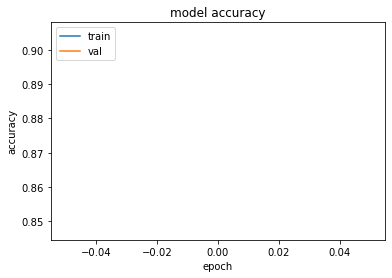

In [15]:
from matplotlib import pyplot as plt

plt.plot(teacher_history.history['sparse_categorical_accuracy'])
plt.plot(teacher_history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
from keras.callbacks import ModelCheckpoint
checkpoint_filepath = 'model_final_distille_14_inputs'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

Using TensorFlow backend.


In [17]:
# Create Distiller instance
distiller = Distiller(student=student, teacher=teacher)

# Compile Distiller model
distiller.compile(
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.05,
    temperature=5,
)

# Distill knowledge from teacher to student (will take around 3 mins with GPU enabled)
distiller_history = distiller.fit(np.array(X_trainS), np.array(y_train),validation_data=(X_testS,y_test), epochs=1, batch_size=1, callbacks=[model_checkpoint_callback]) # increase the number of eochs to make it work

TypeError: compile() got an unexpected keyword argument 'loss'

In [ ]:
from matplotlib import pyplot as plt

plt.plot(distiller_history.history['sparse_categorical_accuracy'])
plt.plot(distiller_history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
sel_input = [ True,  True,  True, False, False, False, False, False,  True,  True, False, False,
 False, False]

In [22]:
X_trainS_resample = np.array(X_trainS)[:,sel_input]
X_testS_resample = np.array(X_testS)[:,sel_input]
print(X_trainS_resample.shape)
print(X_testS_resample.shape)

(234301, 5)
(58679, 5)


In [23]:
# Teacher model
def create_big_model():
  tf.random.set_seed(42)
  model = keras.models.Sequential([
    keras.layers.Dense(512, input_dim = 5 ,activation='relu'),
    keras.layers.Dense(2)
  ])

  return model



# Student model
def create_small_model():
  tf.random.set_seed(42)
  model = keras.models.Sequential([
    keras.layers.Dense(100, input_dim = 5, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(2)
  ])

  return model

In [24]:
# Create the teacher
teacher = create_big_model()
student = create_small_model()

In [25]:
# Compile the teacher model
teacher.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Notice from_logits param is set to True
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model and save the training history (will take from 5 to 10 minutes depending on the GPU you were assigned to)
teacher_history = teacher.fit(np.array(X_trainS_resample), y_train, epochs=1, batch_size=1, validation_data=(X_testS_resample, y_test))

234301/234301 [==============================] - 177s 756us/step - loss: 0.3725 - sparse_categorical_accuracy: 0.8071 - val_loss: 0.3110 - val_sparse_categorical_accuracy: 0.8406


In [ ]:
from matplotlib import pyplot as plt

plt.plot(teacher_history.history['sparse_categorical_accuracy'])
plt.plot(teacher_history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
checkpoint_filepath = 'model_final_distille_5_inputs'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

In [28]:
# Create Distiller instance
distiller = Distiller(student=student, teacher=teacher)

# Compile Distiller model
distiller.compile(
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.05,
    temperature=5,
)

# Distill knowledge from teacher to student (will take around 3 mins with GPU enabled)
distiller_history = distiller.fit(np.array(X_trainS_resample), np.array(y_train),validation_data=(X_testS_resample,y_test), epochs=1, batch_size=1, callbacks=[model_checkpoint_callback])

132246/234301 [===============>..............] - ETA: 1:21 - sparse_categorical_accuracy: 0.8168 - student_loss: 0.3607 - distillation_loss: 0.0051- ETA: 2:55 - sparse_categorical_accuracy: 0 - ETA: 2:45 - sparse_categorical_accuracy: 0.7679 - student_loss: 0.4696 - distillation_loss: - ETA: 2:37 - sparse_categorical_accuracy: 0.7779 - - ETA: 2:35 - sparse_categorical_ac - ETA: 2:28 - sparse_categorical_accuracy: 0.7884 - student_loss: 0.4174  - ETA: 2:27 - sparse_categori - ETA: 2:10 - sparse_categorical_accuracy: 0.8002 - student_loss: 0.3922 - d - ETA: 2:09 - sparse_categorical_accurac - ETA: 2:05 - sparse_categorical_accuracy: 0.8021 - student_loss: 0.3883 - distillati - ETA: 2:04 - sparse_categorical_accuracy: 0.8026 - student_loss: 0.3875 - dist - ETA: 2:03 - sparse_categorical_ - ETA: 1:59 - sparse_categorical_accuracy: 0.8049 - student_loss: 0.3832 - distillation_l - ETA: 1:59 - sparse_categorical_accuracy: 0.8052 - student_loss: 0.3828 - distil - ETA: 1:58 - sparse_categorical

KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt

plt.plot(distiller_history.history['sparse_categorical_accuracy'])
plt.plot(distiller_history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()